<a href="https://colab.research.google.com/github/LeMat11/ME5920/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


Subset size: 1000
One sample shape: torch.Size([1, 28, 28]) label: 1


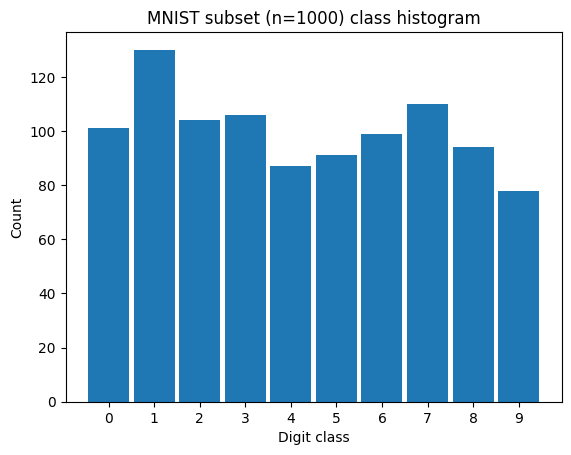

Batched images shape: torch.Size([40, 25, 1, 28, 28])
Batched labels shape: torch.Size([40, 25])


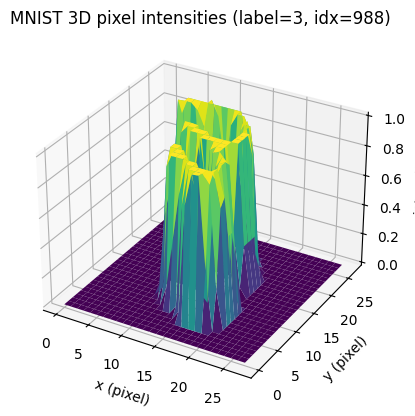

In [1]:
# HW 2.1 MNIST Images
# If needed (Colab): !pip -q install einops

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from einops import rearrange
import numpy as np

# ----------------------------
# 1) Download MNIST + subset of 1000
# ----------------------------
transform = transforms.ToTensor()  # returns tensor in [0,1], shape [1,28,28]

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Make a deterministic subset of 1000 samples (optional but nice for reproducibility)
torch.manual_seed(11)
indices = torch.randperm(len(mnist_train))[:1000].tolist()
mnist_subset = Subset(mnist_train, indices)

print("Subset size:", len(mnist_subset))
x0, y0 = mnist_subset[0]
print("One sample shape:", x0.shape, "label:", y0)  # should be torch.Size([1,28,28])

# ----------------------------
# 2) Plot histogram of classes in subset
# ----------------------------
labels = [mnist_subset[i][1] for i in range(len(mnist_subset))]
plt.figure()
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.9)
plt.xticks(range(10))
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.title("MNIST subset (n=1000) class histogram")
plt.show()

# ----------------------------
# 3) Batch images into groups of 25 using einops
#    Required shape: [1000,28,28] -> [num_batches, 25, 1, 28, 28]
# ----------------------------
# Stack subset into a single tensor
images = torch.stack([mnist_subset[i][0] for i in range(len(mnist_subset))])  # [1000,1,28,28]
labels_t = torch.tensor(labels)  # [1000]

# If you want the intermediate [1000,28,28] (as in prompt), squeeze channel then reshape back
images_1000_28_28 = images.squeeze(1)  # [1000,28,28]

# Make sure 1000 is divisible by 25
batch_size = 25
assert images_1000_28_28.shape[0] % batch_size == 0

# Rearrange to [num_batches, batch_size, 1, 28, 28]
batches = rearrange(images_1000_28_28, '(nb bs) h w -> nb bs 1 h w', bs=batch_size)
label_batches = rearrange(labels_t, '(nb bs) -> nb bs', bs=batch_size)

print("Batched images shape:", batches.shape)       # [40,25,1,28,28]
print("Batched labels shape:", label_batches.shape) # [40,25]

# ----------------------------
# 4) Randomly select an image and plot it in 3D
# ----------------------------
import random
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

idx = random.randint(0, len(mnist_subset)-1)
img, lab = mnist_subset[idx]  # img: [1,28,28]
img2d = img.squeeze(0).numpy()  # [28,28]

# Create x,y grid
x = np.arange(28)
y = np.arange(28)
X, Y = np.meshgrid(x, y)
Z = img2d  # pixel intensity

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')  # don't set colors per your default plotting preference
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")
ax.set_zlabel("intensity")
ax.set_title(f"MNIST 3D pixel intensities (label={lab}, idx={idx})")
plt.show()


Cloning into 'ME5920'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 4), reused 24 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 40.33 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/ME5920/ME5920/ME5920
total 32K
drwxr-xr-x 4 root root 4.0K Feb 17 23:25 .
drwxr-xr-x 5 root root 4.0K Feb 17 23:25 ..
-rw-r--r-- 1 root root 6.1K Feb 17 23:25 .DS_Store
drwxr-xr-x 8 root root 4.0K Feb 17 23:25 .git
drwxr-xr-x 3 root root 4.0K Feb 17 23:25 HW1
-rw-r--r-- 1 root root 1.1K Feb 17 23:25 LICENSE
-rw-r--r-- 1 root root    8 Feb 17 23:25 README.md
Data time range: 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Sampling interval (first two rows): 0 days 00:10:00
                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60 

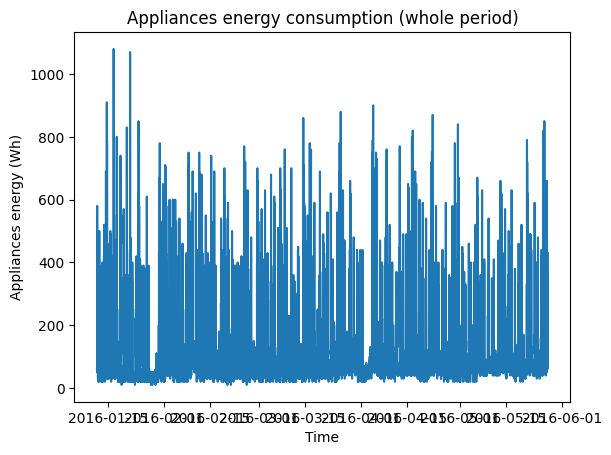

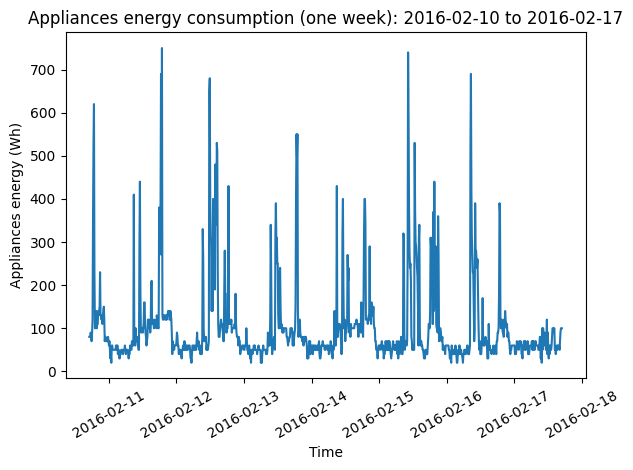

/tmp/ipython-input-3885360722.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  energy_week_hourly = energy_week.resample("1H").mean()


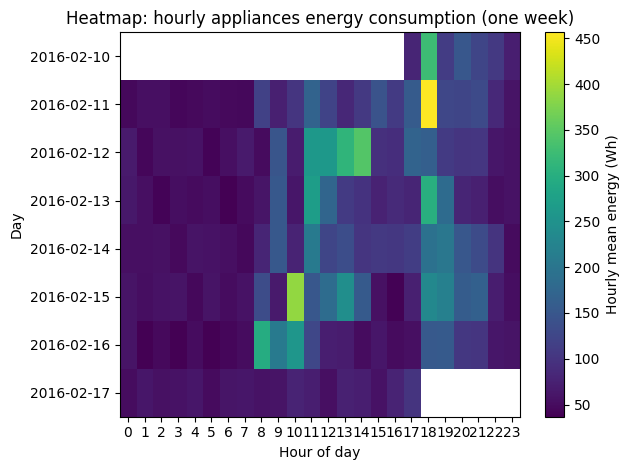

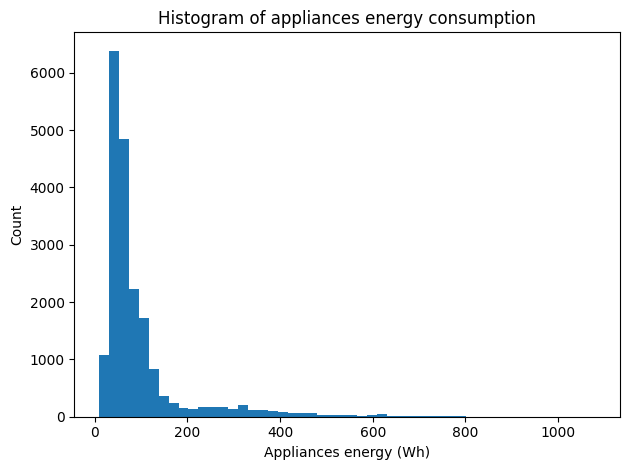

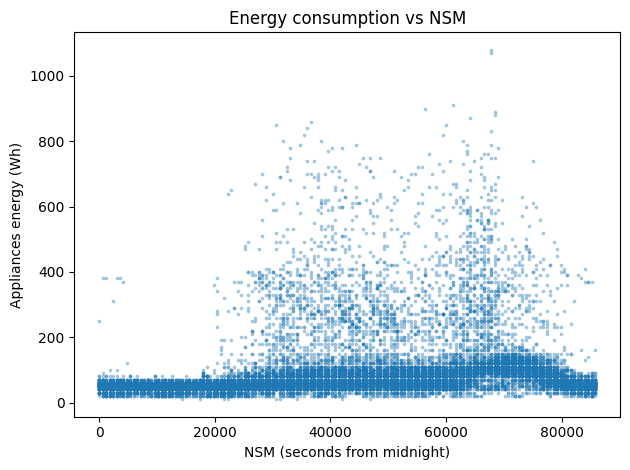

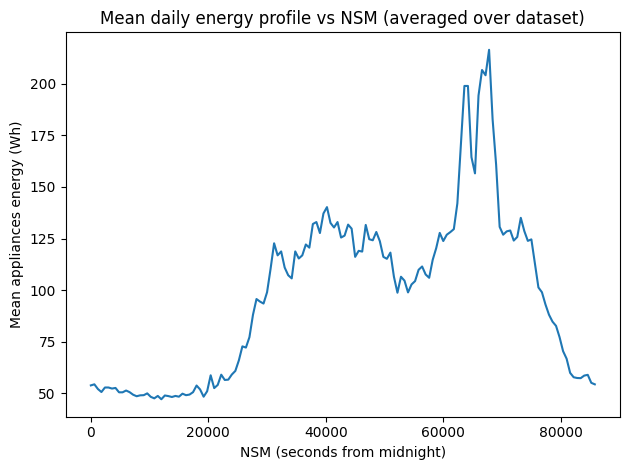

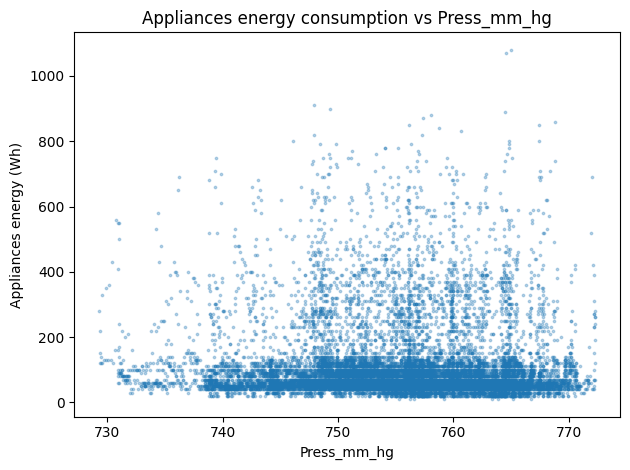

Correlation(Appliances, NSM): 0.21715217211236712
Correlation(Appliances, Press_mm_hg): -0.03488482908163533


In [4]:
# =========================
# HW1 2.2 Time Series
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------- Load data -------------
!rm -rf ME5920
!git clone https://github.com/LeMat11/ME5920.git
%cd ME5920
!ls -lah
csv_path = "HW1/energydata_complete.csv"  # adjust if your notebook is in a subfolder
df = pd.read_csv(csv_path)

# The dataset has a date column (usually named 'date')
# Convert to datetime and set as index for easy slicing
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

# Appliances energy consumption column is typically named "Appliances"
energy = df["Appliances"]

print("Data time range:", df.index.min(), "to", df.index.max())
print("Sampling interval (first two rows):", df.index[1] - df.index[0])
print(df.head())

# ============= 1) Plot whole period + one week zoom =============
plt.figure()
plt.plot(energy.index, energy.values)
plt.xlabel("Time")
plt.ylabel("Appliances energy (Wh)")
plt.title("Appliances energy consumption (whole period)")
plt.show()

# Pick any one week to zoom (choose a start date you like)
# Here we auto-pick a week starting 30 days after the beginning to avoid edge effects
start_week = df.index.min() + pd.Timedelta(days=30)
end_week = start_week + pd.Timedelta(days=7)
energy_week = energy.loc[start_week:end_week]

plt.figure()
plt.plot(energy_week.index, energy_week.values)
plt.xlabel("Time")
plt.ylabel("Appliances energy (Wh)")
plt.title(f"Appliances energy consumption (one week): {start_week.date()} to {end_week.date()}")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ============= 2) Heatmap of hourly consumption for a week =============
# Build an hourly time series for that week
# (mean over each hour; you can also use sum depending on interpretation)
energy_week_hourly = energy_week.resample("1H").mean()

# Create a day x hour matrix: 7 days (rows) x 24 hours (cols)
# Use day labels and hour columns
# We map each timestamp to day index (0..6) and hour (0..23)
tmp = energy_week_hourly.to_frame("Appliances")
tmp["day"] = tmp.index.date
tmp["hour"] = tmp.index.hour

# Pivot to matrix (days x hours)
heat = tmp.pivot_table(index="day", columns="hour", values="Appliances", aggfunc="mean")

# Ensure hours 0..23 exist as columns (fill missing with NaN)
heat = heat.reindex(columns=range(24))

plt.figure()
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Hourly mean energy (Wh)")
plt.xticks(ticks=np.arange(24), labels=np.arange(24))
plt.yticks(ticks=np.arange(len(heat.index)), labels=[str(d) for d in heat.index])
plt.xlabel("Hour of day")
plt.ylabel("Day")
plt.title("Heatmap: hourly appliances energy consumption (one week)")
plt.tight_layout()
plt.show()

# ============= 3) Histogram of energy consumption =============
plt.figure()
plt.hist(energy.values, bins=50)
plt.xlabel("Appliances energy (Wh)")
plt.ylabel("Count")
plt.title("Histogram of appliances energy consumption")
plt.tight_layout()
plt.show()

# ============= 4) NSM feature + plot energy vs NSM =============
# NSM = number of seconds from midnight
nsm = df.index.hour * 3600 + df.index.minute * 60 + df.index.second
df["NSM"] = nsm

plt.figure()
plt.scatter(df["NSM"], df["Appliances"], s=3, alpha=0.3)
plt.xlabel("NSM (seconds from midnight)")
plt.ylabel("Appliances energy (Wh)")
plt.title("Energy consumption vs NSM")
plt.tight_layout()
plt.show()

# Optional: show the daily pattern more clearly by averaging by NSM "bucket" (e.g., per minute)
# This is NOT required but makes the pattern obvious
df_tmp = df.copy()
df_tmp["NSM_min"] = (df_tmp["NSM"] // 60).astype(int)  # bucket by minute
sm_profile = df_tmp.groupby("NSM_min")["Appliances"].mean()

plt.figure()
plt.plot(sm_profile.index * 60, sm_profile.values)
plt.xlabel("NSM (seconds from midnight)")
plt.ylabel("Mean appliances energy (Wh)")
plt.title("Mean daily energy profile vs NSM (averaged over dataset)")
plt.tight_layout()
plt.show()

# ============= 5) Energy vs Press_mm_hg =============
# Column name in this dataset is typically "Press_mm_hg"
if "Press_mm_hg" not in df.columns:
    raise KeyError("Column 'Press_mm_hg' not found. Please check the CSV column names.")

plt.figure()
plt.scatter(df["Press_mm_hg"], df["Appliances"], s=3, alpha=0.3)
plt.xlabel("Press_mm_hg")
plt.ylabel("Appliances energy (Wh)")
plt.title("Appliances energy consumption vs Press_mm_hg")
plt.tight_layout()
plt.show()

# Optional: correlation numbers (helpful for your comment in 6)
corr_nsm = df["Appliances"].corr(df["NSM"])
corr_press = df["Appliances"].corr(df["Press_mm_hg"])
print("Correlation(Appliances, NSM):", corr_nsm)
print("Correlation(Appliances, Press_mm_hg):", corr_press)


**Comment on why NSM and Press_mm_hg are major contributing factors:**

- NSM (seconds from midnight) captures strong daily/diurnal usage patterns. Human activity and appliance usage
  (cooking, lighting, HVAC schedules, occupancy) typically repeat each day, so time-of-day is highly predictive.
- Press_mm_hg is linked to weather systems and seasonal/short-term atmospheric changes. Weather affects indoor
  conditions and HVAC/ventilation/dehumidification needs, which can indirectly drive appliance energy usage.
  Therefore, pressure can act as a proxy for weather-related energy demand variations.

Files found in HW1: ['Agricultural_Image_Analytics', 'airfoil_self_noise.dat', 'hw1.ipynb', 'energydata_complete.csv']
Loading: HW1/airfoil_self_noise.dat
Data shape: (1503, 6)


,Frequency,AngleOfAttack,ChordLength,Velocity,SuctionThickness,SoundPressureLevel
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461



--- Descriptive Statistics ---


,Mean,Variance,Median,Kurtosis,Skewness,Range
Frequency,2886.380572,9.938717e+06,1600.000000,5.708685,2.137084,19800.000000
AngleOfAttack,6.782302,3.502424e+01,5.400000,-0.412951,0.689164,22.200000
ChordLength,0.136548,8.749868e-03,0.101600,-1.037964,0.457457,0.279400
Velocity,50.860745,2.425116e+02,39.600000,-1.563951,0.235852,39.600000
SuctionThickness,0.011140,1.729287e-04,0.004957,2.218903,1.702165,0.058011
SoundPressureLevel,124.835943,4.759146e+01,125.721000,-0.314187,-0.418952,37.607000


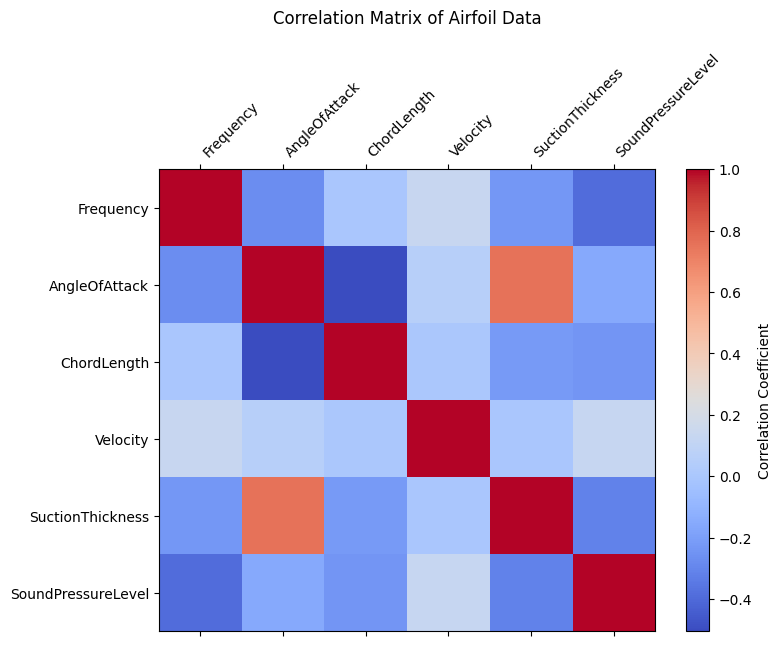

In [7]:
# =========================
# HW1 2.3 Multi-variate
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Browse/Find the file
# We look into HW1 for the dataset (since we are already in the repo root)
search_dir = "HW1"
if not os.path.exists(search_dir):
    # Fallback: maybe we are not in the repo dir yet?
    if os.path.exists("ME5920/HW1"):
        search_dir = "ME5920/HW1"

files_in_dir = os.listdir(search_dir)
print("Files found in HW1:", files_in_dir)

# We expect a file like 'airfoil_self_noise.dat'
# Let's try to identify it automatically based on 'airfoil' in the name
possible_files = [f for f in files_in_dir if "airfoil" in f.lower()]
if len(possible_files) > 0:
    target_file = possible_files[0]
else:
    # Fallback if naming is different, but this is the standard name
    target_file = "airfoil_self_noise.dat"

file_path = os.path.join(search_dir, target_file)
print(f"Loading: {file_path}")

# 2) Load data
# The NASA airfoil dataset is typically tab-separated and has no header
try:
    # Try tab separator first
    df_air = pd.read_csv(file_path, sep='\t', header=None)
except:
    # Fallback to whitespace separator
    df_air = pd.read_csv(file_path, sep=r'\s+', header=None)

# Assign columns based on problem description:
# 1. Frequency, in Hz.
# 2. Angle of attack, in degrees.
# 3. Chord length, in meters.
# 4. Free-stream velocity, in meters per second.
# 5. Suction side displacement thickness, in meters.
# Output: Scaled sound pressure level, in decibels.
cols = [
    "Frequency",
    "AngleOfAttack",
    "ChordLength",
    "Velocity",
    "SuctionThickness",
    "SoundPressureLevel"
]

# Validate shape and assign columns
if df_air.shape[1] == len(cols):
    df_air.columns = cols
else:
    print(f"Warning: Data has {df_air.shape[1]} columns, expected {len(cols)}. Check delimiter.")

print("Data shape:", df_air.shape)
display(df_air.head())

# 3) Compute Descriptive Statistics
# Requirements: Mean, Variance, Median, Kurtosis, Skewness, Range
desc_stats = pd.DataFrame(index=df_air.columns)
desc_stats['Mean'] = df_air.mean()
desc_stats['Variance'] = df_air.var()
desc_stats['Median'] = df_air.median()
desc_stats['Kurtosis'] = df_air.kurtosis()
desc_stats['Skewness'] = df_air.skew()
desc_stats['Range'] = df_air.max() - df_air.min()

print("\n--- Descriptive Statistics ---")
display(desc_stats)

# Optional: Visualization for Multi-variate analysis (Correlation Matrix)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(df_air.corr(), cmap='coolwarm', aspect='auto')
fig.colorbar(cax, label="Correlation Coefficient")

# Set ticks and labels
ax.set_xticks(range(len(df_air.columns)))
ax.set_xticklabels(df_air.columns, rotation=45, ha='left')
ax.set_yticks(range(len(df_air.columns)))
ax.set_yticklabels(df_air.columns)

plt.title("Correlation Matrix of Airfoil Data", pad=20)
plt.show()